<a href="https://www.kaggle.com/code/araspirbadian/classifying-images-with-intel-images-dataset?scriptVersionId=96794954" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classifying images with Intel image dataset 

In this work, the intel image dataset with 6 categories have been categorized using CNNs. The 6 categories are: 

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,  
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }  

There has been about 14k images for the training and 3k images for test. The images are spread between categories almost equally. 

The trained model has reached a test accuracy of about 75%. Also the RMSE for the dataset has been 3.68. Checking the remaining mistakes, shows that in many cases it is hard for human eyes to predict what cattegory each image should belong to. This is because many images share a lot of the same features. However, further tuning the model and possibly using an ensemble of models could still possibly improve the performance closer to the human level errors. 


# The model

Here is how the summary of the model and its parameters: 

Model: "sequential"
_________________________________________________________________

 conv2d (Conv2D)             (None, 139, 139, 32)      13856     
 max_pooling2d(MaxPooling2D)  (None, 69, 69, 32)       0        
 conv2d_1 (Conv2D)           (None, 66, 66, 64)        32832     
 max_pooling2d_1(MaxPooling2D)  (None, 33, 33, 64)     0         
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        65600     
 max_pooling2d_2(MaxPooling2D)  (None, 15, 15, 64)     0         
 conv2d_3 (Conv2D)           (None, 12, 12, 128)       131200    
 max_pooling2d_3(MaxPooling2D)  (None, 6, 6, 128)      0         
 flatten (Flatten)           (None, 4608)              0         
 dense (Dense)               (None, 4096)              18878464  
 dense_1 (Dense)             (None, 512)               2097664   
 dense_2 (Dense)             (None, 64)                32832     
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
=================================================================
Total params: 21,252,838
Trainable params: 21,252,838
Non-trainable params: 0
_________________________________________________________________


# Performance characterization

The training and validation losses vs epochs

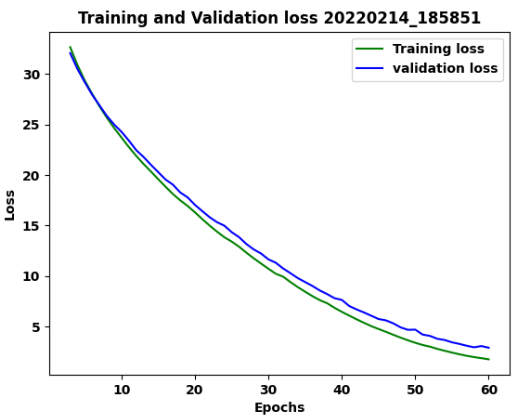

Hera are two sample of 9 images and their predicted categories and their probability in percent

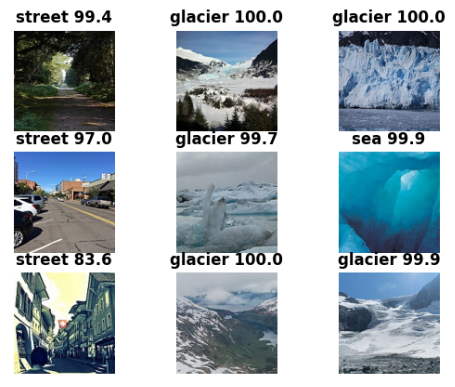

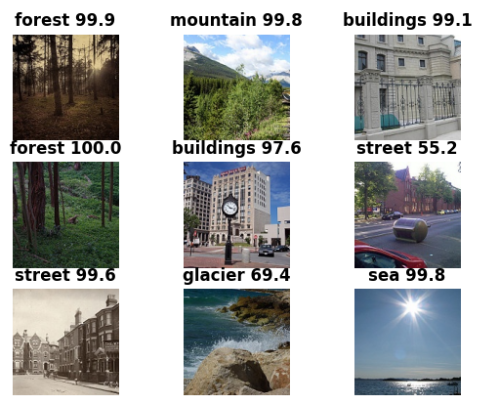

# The code

# Due to the size of the data the code has been run on PyCharm environment to use the personal computer's GPU

Imports:

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from datetime import datetime
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import metrics

functions and classes:

In [ ]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''

    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))

    return LearningRateScheduler(schedule)

class labeling:
    buildings = 0
    forest = 1
    glacier = 2
    mountain = 3
    sea = 4
    street = 5

Preparing the train and test data

In [ ]:
input_shape = (150, 150, 3)
x_train = []
y_train = []
x_test = []
y_test = []

base_fold = r'../input/intel-image-classification'
train_fold = os.path.join(base_fold, 'seg_train')
test_fold = os.path.join(base_fold, 'seg_test')

for lib_ind in os.listdir(train_fold):
    lib_ind_fold = os.path.join(train_fold, lib_ind)
    for pic in os.listdir(lib_ind_fold):
        pic_read = np.asarray(Image.open(os.path.join(lib_ind_fold, pic)).convert('RGB'))
        if pic_read.shape == input_shape:
            x_train.append(pic_read)
            y_train.append(eval('labeling.' + lib_ind))

for lib_ind in os.listdir(test_fold):
    lib_ind_fold = os.path.join(test_fold, lib_ind)
    for pic in os.listdir(lib_ind_fold):
        pic_read_test = np.asarray(Image.open(os.path.join(lib_ind_fold, pic)).convert('RGB'))
        if pic_read_test.shape == input_shape:
            x_test.append(pic_read_test)
            y_test.append(eval('labeling.' + lib_ind))

x_train = np.array(x_train)/255.0
y_train = np.array(y_train)
x_test = np.asarray(x_test)/255.0
y_test = np.array(y_test)

onehot_encoder = OneHotEncoder(sparse=False)
y_train_reshaped = y_train.reshape(-1, 1)
y_train_one_hot = onehot_encoder.fit_transform(y_train_reshaped)

onehot_encoder = OneHotEncoder(sparse=False)
y_test_reshaped = y_test.reshape(-1, 1)
y_test_one_hot = onehot_encoder.fit_transform(y_test_reshaped)

The model definition:

In [ ]:
W_init = keras.initializers.RandomNormal(mean=0.0, stddev=1e-1)
b_init = keras.initializers.RandomNormal(mean=0.5, stddev=1e-1)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (12, 12), activation='relu', input_shape=input_shape, kernel_initializer=W_init,
                        bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init,
                        kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init,
                        kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (4, 4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init,
                        kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.Dense(512, activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.Dense(64, activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.Dense(6, activation='softmax', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4))
])

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

file_date = datetime.now().strftime("%Y%m%d_%H%M%S")
lr_sched = step_decay_schedule(initial_lr=5e-4, decay_factor=0.95, step_size=2)

history = model.fit(x_train, y_train_one_hot, batch_size=64, epochs=60, callbacks=[lr_sched], validation_data=(x_test, y_test_one_hot), verbose=1)


# Plotting the losses and images 

In [ ]:
loss_train = history.history['loss'][2:]
loss_val = history.history['val_loss'][2:]
epochs = range(3, len(history.epoch) + 1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss ' + file_date)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


x_random = np.random.randint(1, x_test.shape[0], 10)
y_pred = model.predict(x_test[x_random, :, :, :])
MSE_10 = metrics.mean_squared_error(y_test[:10], y_pred.argmax(axis=1))
RMSE = np.sqrt(MSE_10)

num_to_name = pd.Series(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], dtype="category")

for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.title('{} {}'.format(num_to_name[y_pred[i, :].argmax()], np.round(y_pred[i, :].max() * 100, 1)))
    plt.imshow(x_test[x_random[i], :, :, :])
plt.show()